<a href="https://colab.research.google.com/github/shankarb14/glove/blob/master/glove_%2B_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Download the GloVe embeddings   
!wget http://nlp.stanford.edu/data/glove.6B.zip  
!unzip glove.6B.zip 

--2021-07-13 17:26:05--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-13 17:26:05--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-13 17:26:06--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

Importing different libraries 

In [ ]:
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer #word stemmer class
lemma = WordNetLemmatizer()
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding

Reading csv file

In [ ]:
df=pd.read_csv('/content/train (1).csv')

Create a list of punctuation marks

In [ ]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '•', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']


Code to replace punctuations with whitespaces

In [ ]:
def clean_text(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, ' ')
    return x


 Cleaning URLs, twitter user_handles, punctuations, whitespaces and converting to lowercase

In [ ]:
df['Cleaned'] = df['tweet'].apply(lambda x: re.sub(r'http\S+', '', x))
df['Cleaned'] = df['Cleaned'].apply(lambda x: re.sub("@[\w]*", '', x))
df['Cleaned'] = df['Cleaned'].apply(lambda x: clean_text(x))
df['Cleaned'] = df['Cleaned'].str.lower()
df['Cleaned'] = df['Cleaned'].apply(lambda x:' '.join(x.split()))
df['Sentiment'] = df['label']
df = df.drop(['tweet','label'],axis=1)
print(df.head())


   id                                            Cleaned Sentiment
0   1  the cdc currently reports 99031 deaths in gene...      real
1   2  states reported 1121 deaths a small rise from ...      real
2   3  politically correct woman almost uses pandemic...      fake
3   4  indiafightscorona we have 1524 covid testing l...      real
4   5  populous states can generate large case counts...      real


Reading labels and converting to 1 and 0

In [ ]:
label = df['Sentiment']
label = np.array(list(map(lambda x: 1 if x=="real" else 0, label)))
df.isna().sum()

id           0
Cleaned      0
Sentiment    0
dtype: int64

tokenization and padding the tokens.

In [ ]:
max_length =100

t = Tokenizer()
t.fit_on_texts(df['Cleaned'])
vocab_size = len(t.word_index) + 1
encoded_tweets = t.texts_to_sequences(df['Cleaned'])
padded_tweets = pad_sequences(encoded_tweets, maxlen=max_length, padding='post')

vocab_size = len(t.word_index) + 1

Extracting pretrained  Glove embeddings values

In [ ]:
embeddings_index = dict()
f = open('/content/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

Creating embedding matrix

In [ ]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

spliting data into train and test data.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(padded_tweets, label , test_size = 0.20)

building BiLSTM model

In [ ]:
model_glove = Sequential()
model_glove.add(Embedding(vocab_size, 100, input_length=max_length, weights=[embedding_matrix], trainable=True))
model_glove.add(Bidirectional(LSTM(60, return_sequences=True)))
model_glove.add(Dropout(0.3))
model_glove.add(Bidirectional(LSTM(20)))
model_glove.add(Dropout(0.2))
model_glove.add(Dense(20, activation='relu'))
model_glove.add(Dropout(0.4))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Training model for batch_size 100 and 10 epochs

In [ ]:
history=model_glove.fit(X_train, y_train,batch_size=100, epochs = 10)

Epoch 1/10
52/52 [==============================] - 29s 35ms/step - loss: 0.6507 - accuracy: 0.5965
Epoch 2/10
52/52 [==============================] - 2s 32ms/step - loss: 0.3775 - accuracy: 0.8576
Epoch 3/10
52/52 [==============================] - 2s 33ms/step - loss: 0.2462 - accuracy: 0.9181
Epoch 4/10
52/52 [==============================] - 2s 33ms/step - loss: 0.1727 - accuracy: 0.9467
Epoch 5/10
52/52 [==============================] - 2s 33ms/step - loss: 0.1057 - accuracy: 0.9693
Epoch 6/10
52/52 [==============================] - 2s 33ms/step - loss: 0.0716 - accuracy: 0.9822
Epoch 7/10
52/52 [==============================] - 2s 32ms/step - loss: 0.0436 - accuracy: 0.9881
Epoch 8/10
52/52 [==============================] - 2s 32ms/step - loss: 0.0281 - accuracy: 0.9934
Epoch 9/10
52/52 [==============================] - 2s 32ms/step - loss: 0.0306 - accuracy: 0.9940
Epoch 10/10
52/52 [==============================] - 2s 32ms/step - loss: 0.0446 - accuracy: 0.9903


In [ ]:

from sklearn.metrics import classification_report

predicting label for test data

In [ ]:
y_pred = model_glove.predict(X_test)
y_predN=np.round(y_pred)

printing classification report

In [ ]:
print(classification_report(y_test, y_predN))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       588
           1       0.93      0.94      0.94       696

    accuracy                           0.93      1284
   macro avg       0.93      0.93      0.93      1284
weighted avg       0.93      0.93      0.93      1284



ploting training loss with training accuracy.

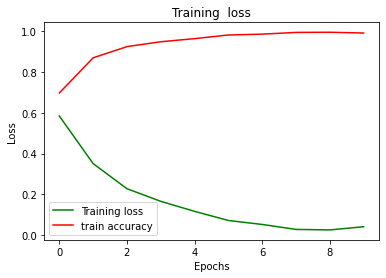

In [ ]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
epochs = range(0,10)
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs,train_acc,'r', label='train accuracy')
plt.title('Training  loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()